In [1]:
#!pip install opencv-python, scikit-image, scipy, pandas, matplotlib, scikit-learn, scikit-learn-intelex

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import chan_vese, active_contour, watershed
from skimage.morphology import erosion, dilation, opening, closing, disk, remove_small_objects
from skimage.measure import label
from skimage import io, color, filters
from scipy import ndimage as ndi
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
base_dir = r'/kaggle/input/cell-counting-roboflow-segmentation-masks/Cell_Counting_dataset_from_roboflow/test/images'
image_path = base_dir + '/Screenshot-2024-08-20-at-3-40-57-PM_png.rf.51490a3f822ef799797a83f5462ccc9a.jpg'

Kích thước ảnh: (640, 640, 3)
Kiểu dữ liệu: uint8
Giá trị pixel min/max: 121/236


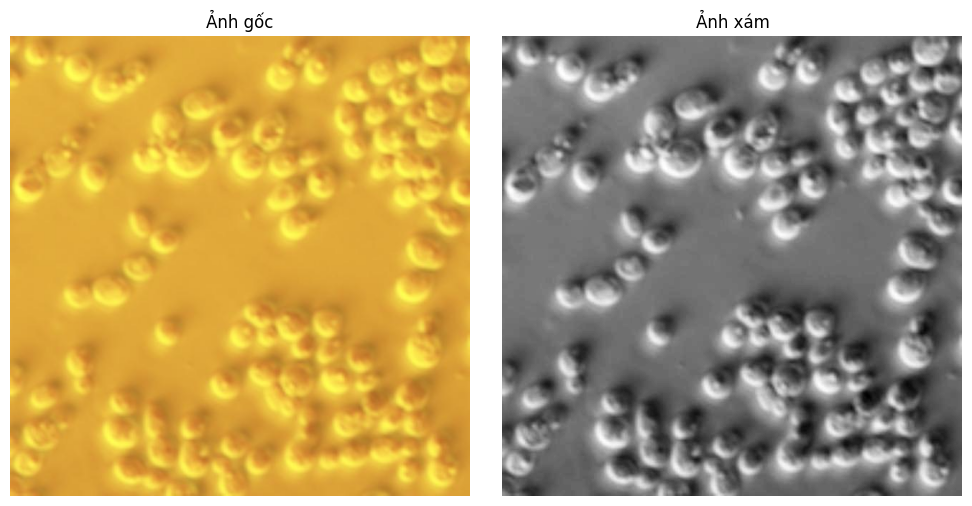

Đang test trên ảnh: /kaggle/input/cell-counting-roboflow-segmentation-masks/Cell_Counting_dataset_from_roboflow/test/images/Screenshot-2024-08-20-at-3-40-57-PM_png.rf.51490a3f822ef799797a83f5462ccc9a.jpg


In [4]:
# Lấy danh sách ảnh trong thư mục test
image_files = [f for f in os.listdir(base_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]

# Chọn 1 ảnh đầu tiên để test
if not image_files:
    raise FileNotFoundError("Không tìm thấy ảnh nào trong thư mục test/")
    
image_path = os.path.join(base_dir, image_files[0])

# Đọc ảnh gốc
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)


print(f"Kích thước ảnh: {image_bgr.shape}")
print(f"Kiểu dữ liệu: {image_bgr.dtype}")
print(f"Giá trị pixel min/max: {gray.min()}/{gray.max()}")

# Hiển thị ảnh gốc
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title(f"Ảnh gốc")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray')
plt.title('Ảnh xám')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Đang test trên ảnh: {image_path}")

# ----------------------------------------------------------------
# 1. PREPROCESSING
# ----------------------------------------------------------------

In [5]:
def preprocess_image(image_path):
    """
    Hàm tiền xử lý ảnh:
    1. Đọc ảnh và chuyển sang ảnh xám.
    2. Áp dụng bộ lọc Gaussian Blur để giảm nhiễu.
    3. Áp dụng bộ lọc Sharpen để làm sắc nét các cạnh.
    4. Áp dụng toán tử đạo hàm (Sobel) để phát hiện cạnh.
    
    Args:
    image_path (str): Đường dẫn đến file ảnh.
    
    Returns:
    numpy.ndarray: Ảnh đã được xử lý và chuyển sang dạng nhị phân.
    """
    # Đọc ảnh xám
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Không tìm thấy ảnh tại đường dẫn: {image_path}")
    
    # Bước 1: Gaussian Blur nhẹ
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Bước 2: Sharpen
    sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
    ])
    sharpened_img = cv2.filter2D(blurred_img, -1, sharpen_kernel)
    
    # Bước 3: Toán tử đạo hàm (Sobel) để tính toán gradient
    grad_x = cv2.Sobel(sharpened_img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(sharpened_img, cv2.CV_64F, 0, 1, ksize=3)
    sobel_img = cv2.magnitude(grad_x, grad_y).astype(np.uint8)

    # Bước 4: Phân đoạn bằng ngưỡng Otsu
    #_, processed_image = cv2.threshold(sobel_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, processed_image = cv2.threshold(sobel_img, 0, 255, cv2.THRESH_OTSU)
    
    return processed_image

# ----------------------------------------------------------------
# 2. SEGMENTATION METHODS
# ----------------------------------------------------------------

In [6]:
def segmentation_methods(image, method="otsu", init_radius=30, min_area=50):
    if method == "otsu":
        # Chuyển sang ảnh xám để xử lý
        if len(image.shape) == 3:
            gray = color.rgb2gray(image)
        else:
            gray = image
        # Otsu thresholding
        threshold_val = filters.threshold_otsu(gray)
        binary_result = gray > threshold_val
        # Chuyển về uint8 binary image
        binary_result = binary_result.astype(np.uint8) * 255

        # Morphological closing để làm mịn
        selem = disk(2)
        binary_bool = binary_result > 0
        closed = closing(binary_bool, selem)
        binary_result = (closed * 255).astype(np.uint8)
        
    elif method == "adaptive":
        # Chuyển sang ảnh xám để xử lý
        if len(image.shape) == 3:
            gray = color.rgb2gray(image)
        else:
            gray = image
        # Adaptive thresholding using local mean
        threshold_val = filters.threshold_local(gray, block_size=35, offset=0.01)
        binary_result = gray > threshold_val

        # Chuyển về uint8 binary image
        binary_result = binary_result.astype(np.uint8) * 255
        
        # Morphological closing để làm mịn
        selem = disk(2)
        binary_bool = binary_result > 0
        closed = closing(binary_bool, selem)
        binary_result = (closed * 255).astype(np.uint8)
        
    elif method == "snake":
        # Active Contour Snake segmentation
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        binary_result = np.zeros_like(image, dtype=np.uint8)
        
        for cnt in contours:
            # Bỏ qua contour quá nhỏ (nhiễu)
            if cv2.contourArea(cnt) < 50:
                continue
            
            # Lấy bounding box quanh contour
            x, y, w, h = cv2.boundingRect(cnt)
            x_center, y_center = x + w//2, y + h//2
            
            # Tạo initial snake
            s = np.linspace(0, 2*np.pi, 200)
            x_init = x_center + init_radius * np.cos(s)
            y_init = y_center + init_radius * np.sin(s)
            init_snake = np.array([y_init, x_init]).T
            
            # Active contour
            snake = active_contour(
                image,
                init_snake,
                alpha=0.015,
                beta=10,
                gamma=0.001,
                w_line=0,
                w_edge=1,
                max_px_move=1.0,
                max_num_iter=500,
                convergence=0.1,
                boundary_condition='periodic'
            )
            
            # Tạo mask từ snake
            mask = np.zeros_like(image, dtype=np.uint8)
            snake_int = np.array(snake, dtype=np.int32)
            cv2.fillPoly(mask, [snake_int], 255)
            binary_result = cv2.bitwise_or(binary_result, mask)
                
    elif method == "watershed":  
        if len(image.shape) == 3:
            img_gray = color.rgb2gray(image)
        else:
            img_gray = image

        # Tạo mở để giảm nhiễu
        selem = disk(1)
        opening_result = opening(img_gray > 0, selem)

        # sure background
        sure_bg = dilation(opening_result, disk(2))

        # Distance transform (cần cho watershed)
        dist_transform = ndi.distance_transform_edt(opening_result)

        # Find sure foreground (threshold tương đối)
        threshold_val = 0.1 * dist_transform.max()
        sure_fg = dist_transform > threshold_val

        # Unknown region
        unknown = sure_bg.astype(bool) ^ sure_fg.astype(bool)

        # Markers
        markers = label(sure_fg)
        markers = markers + 1
        markers[unknown] = 0

        # Watershed trên negative distance (Không loại bỏ theo min_area ở đây)
        labels = watershed(-dist_transform, markers, mask=sure_bg, connectivity=8)

        # Tạo binary image từ labels (gộp mọi label >1)
        binary_result = np.zeros_like(img_gray, dtype=np.uint8)
        
        # Lọc các vùng có area đủ lớn
        for region_label in np.unique(labels):
            if region_label <= 1:  # Bỏ qua background và boundary
                continue
                
            # Tạo mask cho region này
            region_mask = (labels == region_label).astype(np.uint8)
            
            # Kiểm tra area nếu min_area được chỉ định
            if min_area > 0:
                area = np.sum(region_mask)
                if area < min_area:
                    continue
            
            # Morphological closing để làm mịn
            region_mask = closing(region_mask.astype(bool), disk(1)).astype(np.uint8)
            region_mask *= 255
            
            # Gộp vào kết quả cuối
            binary_result = np.maximum(binary_result, region_mask)
            
    elif method == "chanvese":
        # Chan-Vese segmentation
        cv_result = chan_vese(
            image, 
            mu=0.075, 
            lambda1=25, 
            lambda2=35, 
            tol=1e-2, 
            max_num_iter=300, 
            init_level_set="checkerboard", 
            extended_output=True)
        
        phi = cv_result[0]
        mask = phi > 0  # mask nhị phân
        binary_result = (mask * 255).astype("uint8")
        
    else:
        raise ValueError(f"Phương pháp '{method}' không được hỗ trợ!")
    
    return binary_result.astype(np.uint8)

# ----------------------------------------------------------------
# 3. COUNT AND DRAW FUNCTION
# ----------------------------------------------------------------

In [7]:
def count_and_draw(binary_image, original_image_path, method_name="Segmentation", min_area=50):
        # Chuyển binary_image về mảng boolean
        if binary_image.dtype == np.uint8:
            mask = binary_image > 0
        else:
            mask = binary_image.astype(bool)
    
        # Loại bỏ các đối tượng nhỏ (min_area tính theo pixel)
        if min_area is not None and min_area > 0:
            cleaned_mask = remove_small_objects(mask, min_size=int(min_area))
        else:
            cleaned_mask = mask
    
        # Chuyển về uint8 0/255 để dùng OpenCV
        cleaned_uint8 = (cleaned_mask.astype(np.uint8) * 255)
    
        # Tìm contours trên ảnh đã dọn
        contours, _ = cv2.findContours(cleaned_uint8.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        # Lọc contours theo diện tích tối thiểu (dành thêm 1 hàng bảo vệ)
        valid_contours = [c for c in contours if cv2.contourArea(c) >= min_area]
    
        num_objects = len(valid_contours)
    
        # Chuẩn bị ảnh để vẽ
        img_color = None
        if original_image_path is not None:
            img_color = cv2.imread(original_image_path)
            if img_color is None:
                raise FileNotFoundError(f"Image not found: {original_image_path}")
    
        if img_color is None:
            h, w = cleaned_uint8.shape[:2]
            img_color = 255 * np.ones((h, w, 3), dtype=np.uint8)
    
        # Vẽ contours lên ảnh (màu xanh lá)
        cv2.drawContours(img_color, valid_contours, -1, (0, 255, 0), 2)
    
        # Hiển thị bằng matplotlib
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cleaned_uint8, cmap='gray')
        plt.title(f'{method_name} - Cleaned Binary (min_area={min_area})')
        plt.axis('off')
    
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
        plt.title(f'{method_name} - Objects Detected: {num_objects}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
        return num_objects, valid_contours, cleaned_uint8

In [8]:
def running_function(image_path, method="chanvese"):
    # Bước 1: Tiền xử lý
    processed_image = preprocess_image(image_path)
    
    # Bước 2: Phân đoạn
    segmented_binary = segmentation_methods(processed_image, method)
    
    # Bước 3: Đếm và vẽ
    method_names = {
        "chanvese": "Chan-Vese",
        "snake": "Active Contour Snake", 
        "watershed": "Watershed",
        "otsu": "Otsu Thresholding",
        "adaptive": "Adaptive Thresholding"
    }
    
    num_objects, contours, _ = count_and_draw(
        segmented_binary, 
        image_path, 
        method_names.get(method, method)
    )
    
    print(f"[{method}] Number of objects detected: {num_objects}")
    return num_objects

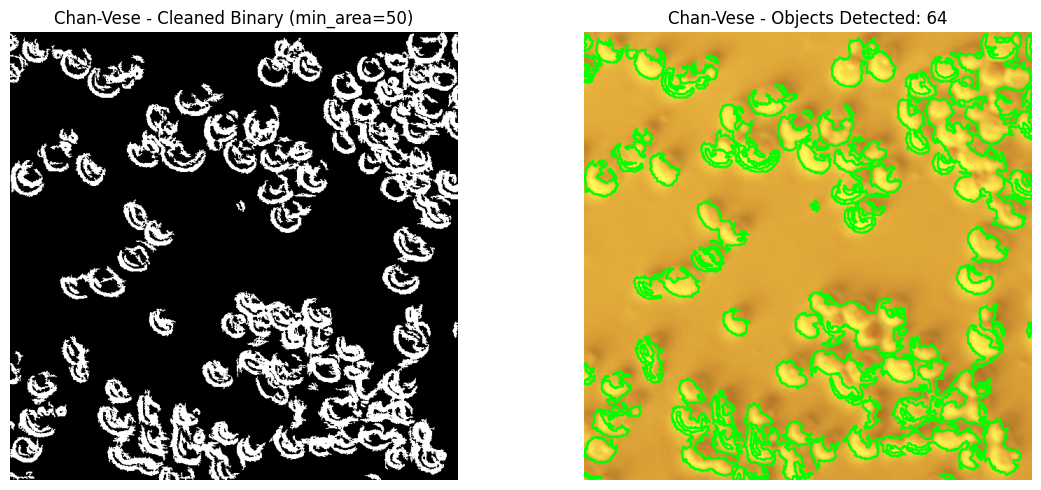

[chanvese] Number of objects detected: 64


64

In [9]:
running_function(image_path, method="chanvese")

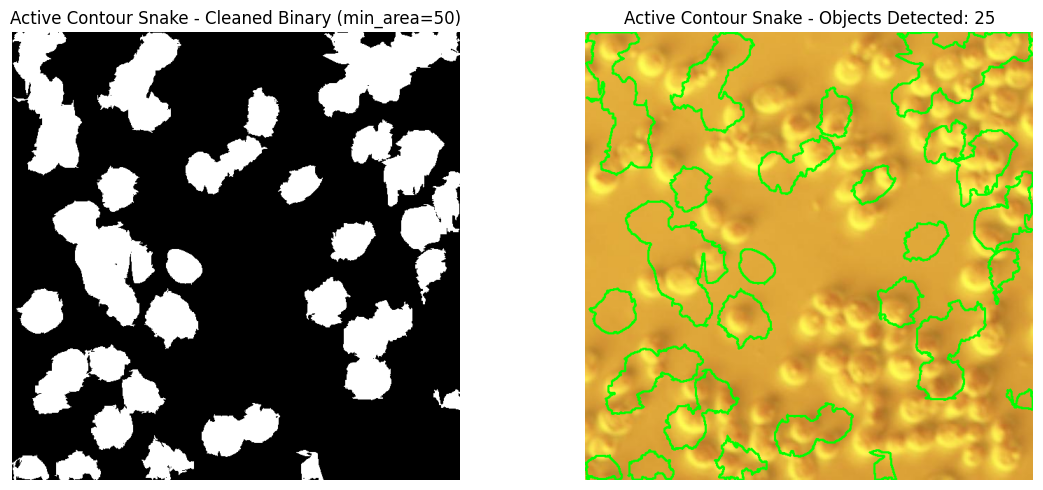

[snake] Number of objects detected: 25


25

In [10]:
running_function(image_path, method="snake")

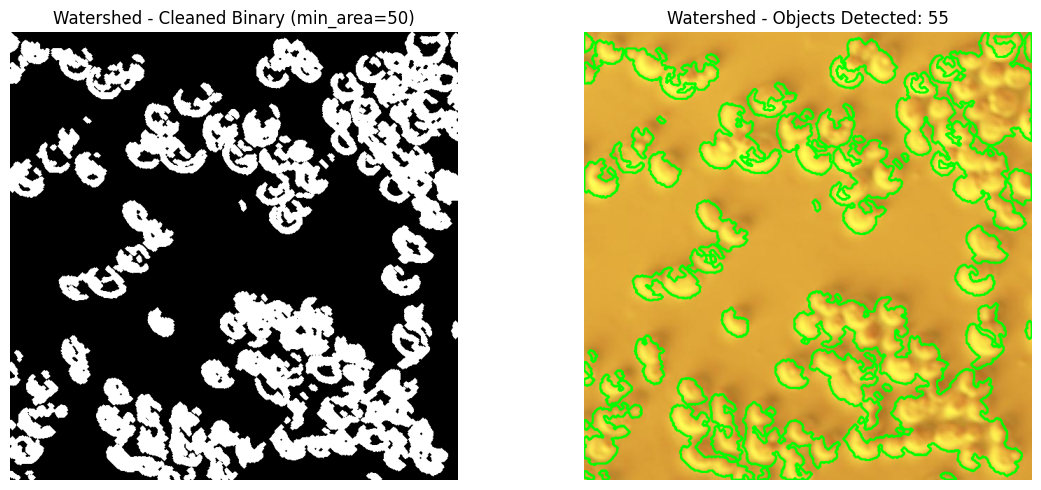

[watershed] Number of objects detected: 55


55

In [11]:
running_function(image_path, method="watershed")

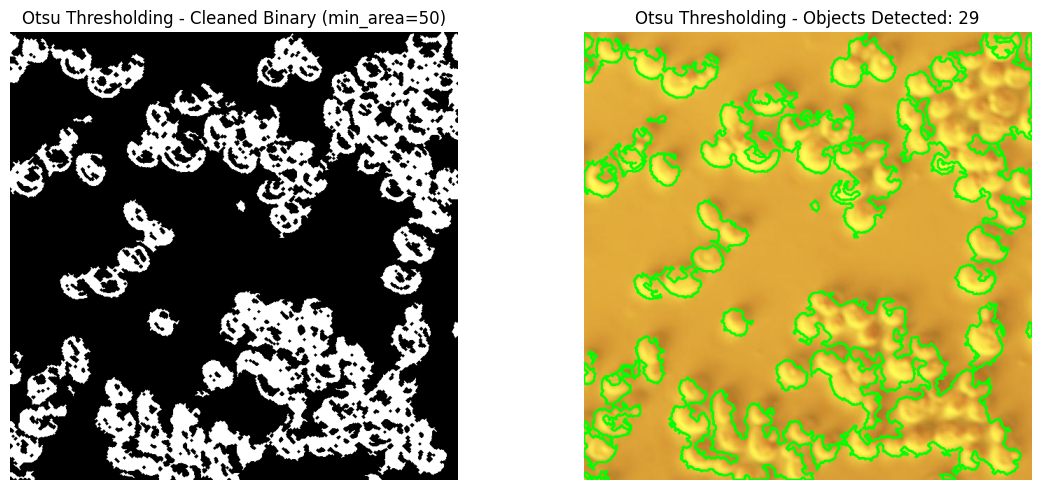

[otsu] Number of objects detected: 29


29

In [12]:
running_function(image_path, method="otsu")

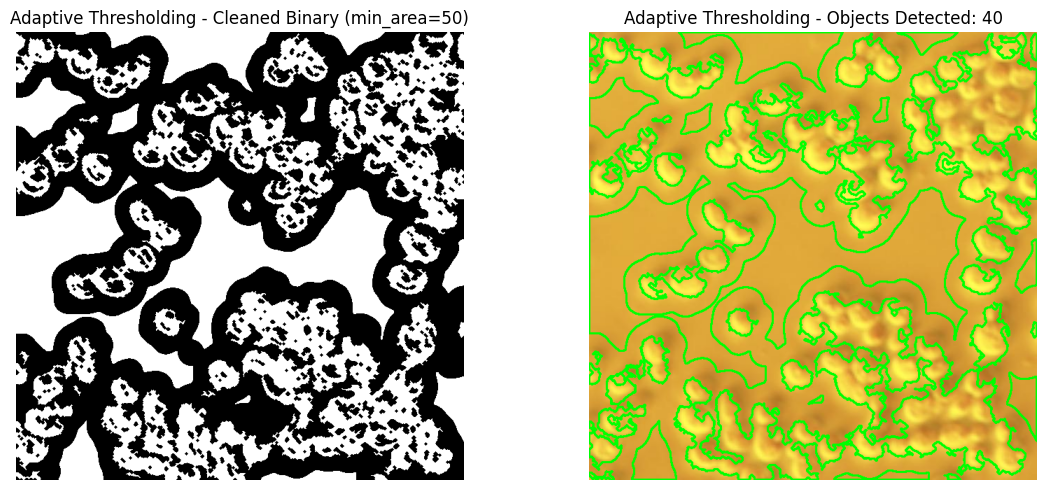

[adaptive] Number of objects detected: 40


40

In [13]:
running_function(image_path, method="adaptive")